In [1]:
import sys
from typing import Iterable
import warnings

import nibabel
from neurolang import frontend as fe
import numpy as np
import pandas as pd
import nilearn.datasets
import nilearn.image
import nilearn.plotting


import xml.etree.ElementTree as ET
import json
from neurolang.frontend import NeurolangPDL, ExplicitVBR, ExplicitVBROverlay
from rdflib import RDFS
from sklearn.model_selection import KFold

from typing import Callable, Iterable

/Users/gzanitti/.local/lib/python3.8/site-packages/scikit_learn-0.23.2-py3.8-macosx-10.9-x86_64.egg/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
cogAt = nilearn.datasets.utils._fetch_files(
    nilearn.datasets.utils._get_dataset_dir('CogAt'),
    [
        (
            'cogat.xml',
            'http://data.bioontology.org/ontologies/COGAT/download?'
            'apikey=8b5b7825-538d-40e0-9e9e-5ab9274a9aeb&download_format=rdf',
            {'move': 'cogat.xml'}
        )
    ]
)[0]

In [3]:
nl = NeurolangPDL()
nl.load_ontology(cogAt)

In [4]:
# NeuroSynth
mni_mask = nilearn.image.resample_img(
    nibabel.load(nilearn.datasets.fetch_icbm152_2009()["gm"]),
    np.eye(3) * 2
)

ns_database_fn, ns_features_fn = nilearn.datasets.utils._fetch_files(
    "neurolang",
    [
        (
            "database.txt",
            "https://github.com/neurosynth/neurosynth-data"
            "/raw/master/current_data.tar.gz",
            {"uncompress": True},
        ),
        (
            "features.txt",
            "https://github.com/neurosynth/neurosynth-data"
            "/raw/master/current_data.tar.gz",
            {"uncompress": True},
        ),
    ],
)

ns_database = pd.read_csv(ns_database_fn, sep="\t")
ns_database = ns_database[["x", "y", "z", "id"]]

ns_features = pd.read_csv(ns_features_fn, sep="\t")
ns_docs = ns_features[["pmid"]].drop_duplicates()
ns_terms = pd.melt(
    ns_features, var_name="term", id_vars="pmid", value_name="TfIdf"
).query("TfIdf > 1e-3")[["term", "pmid"]]

In [5]:
SelectedStudy = nl.add_uniform_probabilistic_choice_over_set(
    ns_docs, name="SelectedStudy"
)

In [6]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

ns_doc_folds = pd.concat(
    ns_docs.iloc[train].assign(fold=[i] * len(train))
    for i, (train, _) in enumerate(kfold.split(ns_docs))
)


StudyFolds = nl.add_tuple_set(ns_doc_folds, name='StudyFolds')

TermInStudy = nl.add_tuple_set(ns_terms, name="TermInStudy")
FocusReported = nl.add_tuple_set(ns_database, name="FocusReported")
Voxel = nl.add_tuple_set(
    nibabel.affines.apply_affine(
        mni_mask.affine,
        np.transpose(mni_mask.get_fdata().nonzero())
    ),
    name='Voxel'
)

label = nl.new_symbol(name=str(RDFS.label))
related = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#related')
altLabel = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#altLabel')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))

In [7]:
@nl.add_symbol
def first_word(name: str) -> str:
    return name.split(" ")[0]

@nl.add_symbol
def mean(iterable: Iterable) -> float:
    return np.mean(iterable)


@nl.add_symbol
def std(iterable: Iterable) -> float:
    return np.std(iterable)

@nl.add_symbol
def agg_create_region_overlay_MNI(
    x: Iterable, y: Iterable, z: Iterable, p: Iterable
) -> ExplicitVBR:
    voxels = nibabel.affines.apply_affine(
        np.linalg.inv(mni_mask.affine),
        np.c_[x, y, z]
    )
    return ExplicitVBROverlay(
        voxels, mni_mask.affine, p, image_dim=mni_mask.shape
    )

nl.add_symbol(np.exp, name="exp", type_=Callable[[float], float])

exp: typing.Callable[[float], float] = <ufunc 'exp'>

## Single term

### Awareness

In [8]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'awareness')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_aw = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

In [9]:
res_aw['FilteredByTerm'].as_pandas_dataframe().t.unique()

array(['awareness'], dtype=object)

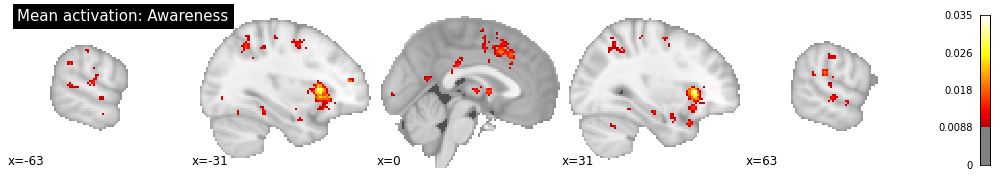

In [39]:
img_query = res_aw['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    title='Mean activation: Awareness',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

### Consciousness

In [11]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'consciousness')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_con = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

In [12]:
res_con['FilteredByTerm'].as_pandas_dataframe().t.unique()

array(['consciousness'], dtype=object)

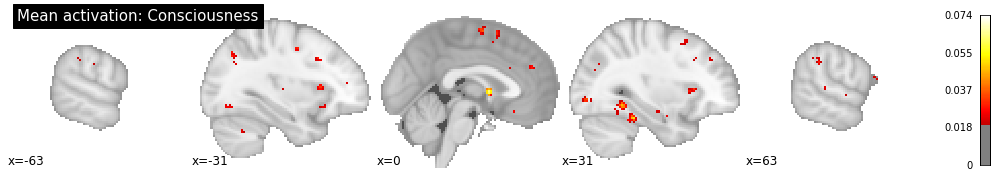

In [38]:
img_query = res_con['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    title='Mean activation: Consciousness',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

## Segregation

### Awareness

In [14]:
with nl.scope as e:
    
    e.FilteredAwareness[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'awareness')
    )
    
    e.FilteredConsciousness[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'consciousness')
    )
    
    e.FilteredByTerm['awareness', e.s] = (
        e.FilteredAwareness[e.s] &
        ~(e.FilteredConsciousness[e.s])
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_seg_aw = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

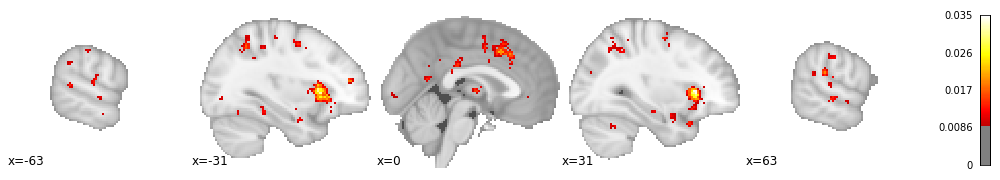

In [15]:
img_query = res_seg_aw['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

### Consciousness

In [16]:
with nl.scope as e:
    
    e.FilteredAwareness[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'awareness')
    )
    
    e.FilteredConsciousness[e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'consciousness')
    )
    
    e.FilteredByTerm['awareness', e.s] = (
        e.FilteredConsciousness[e.s] &
        ~(e.FilteredAwareness[e.s])
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_seg_con = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

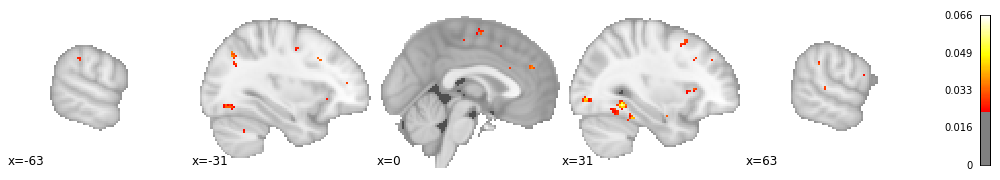

In [17]:
img_query = res_seg_con['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    title=f'Mean activation: consciousness (segregated)',
    ,display_mode='x',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

### Synonym (manual)

In [18]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'awareness')
    )
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'consciousness')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_syn = nl.solve_all()

/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(
/Users/gzanitti/.local/lib/python3.8/site-packages/pandas-1.1.5-py3.8-macosx-10.9-x86_64.egg/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are

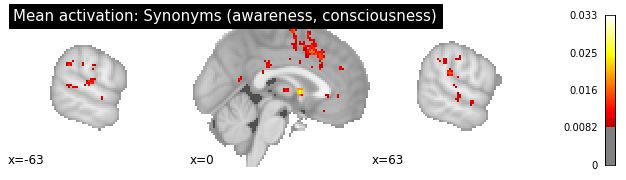

In [227]:
img_query = res_syn['VoxelActivationImg']

result_image = (
    img_query
    .fetch_one()
    [0]
    .spatial_image()
)
img = result_image.get_fdata()
plot = nilearn.plotting.plot_stat_map(
    result_image, threshold=np.percentile(img[img > 0], 95)
    ,display_mode='x',
    title='Mean activation: Synonyms (awareness, consciousness)',
    cut_coords=np.linspace(-63, 63, 5)
)
nilearn.plotting.show()

## Results

In [20]:
def create_region(x, y, z, it):
    voxels = nibabel.affines.apply_affine(
        np.linalg.inv(mni_mask.affine),
        np.c_[x, y, z]
    )
    return fe.ExplicitVBR(voxels, it.affine, image_dim=it.shape)

In [229]:
thr_val = 95

summary_syn = res_syn['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_syn.prob_mean[summary_syn.prob_mean > 0], thr_val)
summary_syn = summary_syn[summary_syn.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_aw = res_aw['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_aw.prob_mean[summary_aw.prob_mean > 0], thr_val)
summary_aw = summary_aw[summary_aw.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_con = res_con['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_con.prob_mean[summary_con.prob_mean > 0], thr_val)
summary_con = summary_con[summary_con.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_seg_aw = res_seg_aw['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_seg_aw.prob_mean[summary_seg_aw.prob_mean > 0], thr_val)
summary_seg_aw = summary_seg_aw[summary_seg_aw.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_seg_con = res_seg_con['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_seg_con.prob_mean[summary_seg_con.prob_mean > 0], thr_val)
summary_seg_con = summary_seg_con[summary_seg_con.prob_mean > thr].set_index(['x', 'y', 'z'])

suf = {
    'Synonyms (Awareness, Consciousness)': summary_syn,
    'Awareness': summary_aw,
    'Consciousness': summary_con,
    #'seg_aw': summary_seg_aw,
    #'seg_con': summary_seg_con,
}



std Synonyms (Awareness, Consciousness) < Awareness: 4200, std Synonyms (Awareness, Consciousness) > Awareness: 1151, eq: 0 :)
min/max: -0.001181263565491874 0.003848271630732836



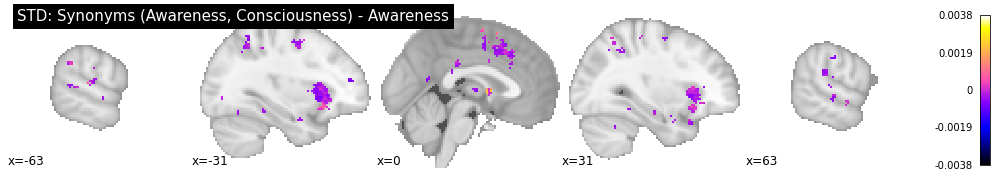

std Synonyms (Awareness, Consciousness) < Consciousness: 1328, std Synonyms (Awareness, Consciousness) > Consciousness: 225, eq: 0 :)
min/max: -0.011453290767103932 0.005511105694874442



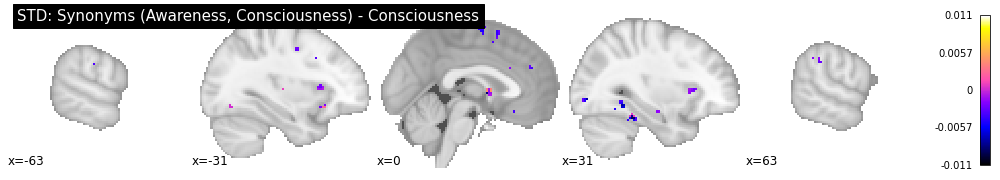

In [230]:
import itertools
from neurolang.regions import region_union

comb = itertools.combinations(suf, 2)

for a, b in comb:
    if a != 'Synonyms (Awareness, Consciousness)':
        continue
    df = suf[a].join(suf[b], lsuffix=f'_{a}', rsuffix=f'_{b}')
    l = f'prob_std_{a}'
    r = f'prob_std_{b}'
    df['res_std'] =  df[l] - df[r]

    m = len(df[df["res_std"] < 0])
    p = len(df[df["res_std"] > 0])
    e = len(df[df["res_std"] == 0])
    
    print(f'std {a} < {b}: {m}, std {a} > {b}: {p}, eq: {e}', ':)' if p < m else '')
    #print(f'{df[l].mean() - df[r].mean()}')
    #print(f'{df["res_std"].mean()}')
    print(f'min/max: {df["res_std"].min()}', df['res_std'].max())
    print()
    
    df = df.reset_index()
    temp = df[['x', 'y', 'z', 'res_std']]

    regions = []
    vox_prob = []
    for x, y, z, p in temp.values:
        r_overlay = create_region(x, y, z, mni_mask)
        vox_prob.append((r_overlay.voxels, p))
        regions.append(r_overlay)

    regions = region_union(regions)

    prob_img_nl = nibabel.spatialimages.SpatialImage(
        np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
    )
    for v, p in vox_prob:
        prob_img_nl.dataobj[tuple(v.T)] = p
        
    nilearn.plotting.plot_stat_map(
        prob_img_nl, 
        title=f'STD: {a} - {b}', 
        display_mode='x',
        cmap='gnuplot2',
        cut_coords=np.linspace(-63, 63, 5),
    )
    nilearn.plotting.show()

In [200]:
result_syn = res_syn['Result'].as_pandas_dataframe()
thr = np.percentile(result_syn.PROB[result_syn.PROB > 0], thr_val)
result_syn = result_syn[result_syn.PROB > thr].set_index(['x', 'y', 'z', 'fold'])

result_aw = res_aw['Result'].as_pandas_dataframe()
thr = np.percentile(result_aw.PROB[result_aw.PROB > 0], thr_val)
result_aw = result_aw[result_aw.PROB > thr].set_index(['x', 'y', 'z', 'fold'])

result_con = res_con['Result'].as_pandas_dataframe()
thr = np.percentile(result_con.PROB[result_con.PROB > 0], thr_val)
result_con = result_con[result_con.PROB > thr].set_index(['x', 'y', 'z', 'fold'])

suf = {
    'Synonyms': result_syn,
    'Awareness': result_aw,
    'Consciousness': result_con,
}

/Users/gzanitti/.local/lib/python3.8/site-packages/numpy-1.20.0rc2-py3.8-macosx-10.9-x86_64.egg/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/gzanitti/.local/lib/python3.8/site-packages/numpy-1.20.0rc2-py3.8-macosx-10.9-x86_64.egg/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2304: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2305: RuntimeWarning: divide by zero encountered in double_scalars
  1.0/(Ntot - k))
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10

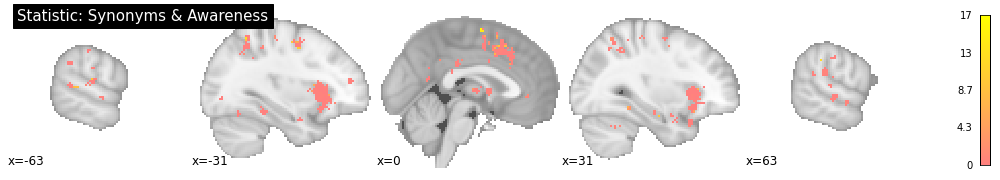

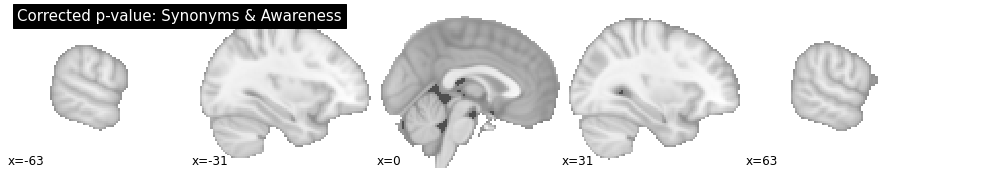

/Users/gzanitti/.local/lib/python3.8/site-packages/numpy-1.20.0rc2-py3.8-macosx-10.9-x86_64.egg/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/gzanitti/.local/lib/python3.8/site-packages/numpy-1.20.0rc2-py3.8-macosx-10.9-x86_64.egg/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2304: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2305: RuntimeWarning: divide by zero encountered in double_scalars
  1.0/(Ntot - k))
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10

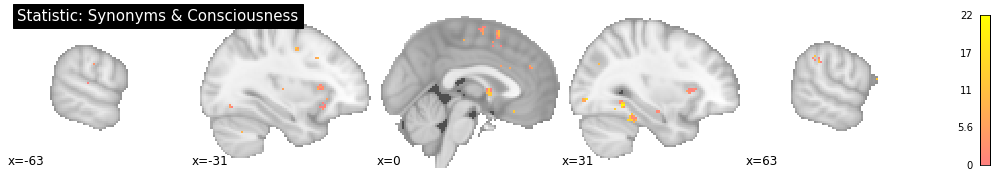

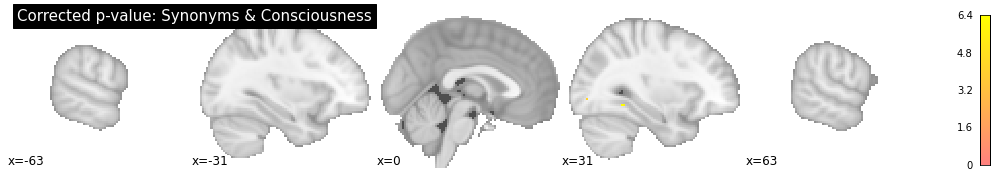

In [221]:
import itertools
from neurolang.regions import region_union
from statsmodels.stats.multitest import multipletests
import scipy

comb = itertools.combinations(suf, 2)

for a, b in comb:
    if a != 'Synonyms':
        continue
    df = suf[a].join(suf[b], lsuffix=f'_{a}', rsuffix=f'_{b}')
    df = df.dropna(axis=0)
    df = df.reset_index()
    
    gp = df.groupby(['x', 'y', 'z'])
    
    res = []
    for g in gp:
        s = g[1][f'PROB_{a}'].values 
        w = g[1][f'PROB_{b}'].values
        l = scipy.stats.bartlett(s, w)
        res.append((g[0], l[0], l[1]))
        
    df2 = pd.DataFrame(res, columns=['voxel', 'statistic', 'pvalue'])
    df2 = df2.dropna(axis=0)
    
    mtest = multipletests([p.pvalue for p in df2.itertuples()], method='bonferroni')
    df2['corrected_pvalue'] = mtest[1]
    
    regions = []
    vox_prob = []
    for v, s, p, cp in df2.values:
        x, y, z = v
        r_overlay = create_region(x, y, z, mni_mask)
        vox_prob.append((r_overlay.voxels, s, cp))
        regions.append(r_overlay)

    regions = region_union(regions)

    p_img = nibabel.spatialimages.SpatialImage(
        np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
    )

    s_img = nibabel.spatialimages.SpatialImage(
        np.zeros(regions.image_dim, dtype=float), affine=mni_mask.affine
    )
    for v, s, cp in vox_prob:
        s_img.dataobj[tuple(v.T)] = s
        if cp < 0.05:
            p_img.dataobj[tuple(v.T)] = 1-np.log(cp)


    nilearn.plotting.plot_stat_map(
        s_img, 
        title=f'Statistic: {a} & {b}', 
        display_mode='x',
        cmap='spring',
        cut_coords=np.linspace(-63, 63, 5),
    )
    nilearn.plotting.plot_stat_map(
        p_img, 
        title=f'Corrected p-value: {a} & {b}', 
        display_mode='x',
        cmap='spring',
        cut_coords=np.linspace(-63, 63, 5),
    )


    nilearn.plotting.show()

In [215]:
df2

,voxel,statistic,pvalue,corrected_pvalue
1,"(-62, -28, 12)",0.115129,0.734379,1.000000
3,"(-62, -22, 30)",3.485355,0.061914,1.000000
4,"(-60, -40, 8)",4.161397,0.041355,1.000000
7,"(-60, -34, 32)",11.546539,0.000679,1.000000
8,"(-60, -32, 30)",0.014620,0.903759,1.000000
...,...,...,...,...
2115,"(62, 20, 16)",12.485247,0.000410,0.784261
2116,"(64, -28, 8)",11.651175,0.000642,1.000000
2117,"(64, -28, 10)",4.819317,0.028142,1.000000
2119,"(64, -24, 8)",0.173652,0.676887,1.000000


In [220]:
1-np.log(0.784261)

1.243013405870091

/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/Users/gzanitti/.local/lib/python3.8/site-packages/scipy-1.6.0-py3.8-macosx-10.9-x86_64.egg/scipy/stats/morestats.py:2439: RuntimeWarning: divide by zero encountered in double_scalars
  W = numer / denom


In [60]:
thr = 95

summary_syn = res_syn['Result'].as_pandas_dataframe()
thr = np.percentile(summary_syn.prob_mean[summary_syn.prob_mean > 0], thr_val)
summary_syn = summary_syn[summary_syn.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_aw = res_aw['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_aw.prob_mean[summary_aw.prob_mean > 0], thr_val)
summary_aw = summary_aw[summary_aw.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_con = res_con['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_con.prob_mean[summary_con.prob_mean > 0], thr_val)
summary_con = summary_con[summary_con.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_seg_aw = res_seg_aw['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_seg_aw.prob_mean[summary_seg_aw.prob_mean > 0], thr_val)
summary_seg_aw = summary_seg_aw[summary_seg_aw.prob_mean > thr].set_index(['x', 'y', 'z'])

summary_seg_con = res_seg_con['ResultSummaryStats'].as_pandas_dataframe()
thr = np.percentile(summary_seg_con.prob_mean[summary_seg_con.prob_mean > 0], thr_val)
summary_seg_con = summary_seg_con[summary_seg_con.prob_mean > thr].set_index(['x', 'y', 'z'])

suf = {
    'Synonyms': summary_syn,
    'Awareness': summary_aw,
    'Consciousness': summary_con,
    'seg_aw': summary_seg_aw,
    'seg_con': summary_seg_con,
}

AttributeError: 'DataFrame' object has no attribute 'prob_mean'

In [48]:
a = 'Synonyms'
b = 'Awareness'
df = suf[a].join(suf[b], lsuffix=f'_{a}', rsuffix=f'_{b}')

In [49]:
df.head()

prob_mean_Synonyms  prob_std_Synonyms  prob_mean_Awareness  \
x   y   z                                                                
-64 -48 30            0.008875           0.001512                  NaN   
    -46 30            0.011029           0.002670             0.009834   
    -40 8             0.010426           0.001777             0.011443   
        10            0.010693           0.001986             0.011578   
    -38 8             0.009389           0.001935             0.010142   

            prob_std_Awareness  
x   y   z                       
-64 -48 30                 NaN  
    -46 30            0.002084  
    -40 8             0.002053  
        10            0.002301  
    -38 8             0.002262

In [50]:
df = df.dropna(axis=0)
df = df.reset_index()

In [54]:
syn = df.prob_mean_Synonyms.values
awa = df.prob_mean_Awareness.values

In [57]:
import scipy

scipy.stats.bartlett(syn, awa)

BartlettResult(statistic=32.102431506511216, pvalue=1.4625415291580402e-08)

<module 'statsmodels.stats.multitest' from '/Users/gzanitti/opt/miniconda3/envs/neurolang/lib/python3.8/site-packages/statsmodels/stats/multitest.py'>

In [339]:
df['res_std'] =  df['prob_std_pain'] - df['prob_std_syn']

In [340]:
len(df[df['res_std'] > 0])

44

In [341]:
len(df[df['res_std'] < 0])

2821

In [342]:
df = df.reset_index()

In [343]:
temp = df[['i', 'j', 'k', 'res_std']]

In [344]:
import numpy as np
#result_data = result.value.to_numpy()
#prob_terms = aux.load_neurosynth_pain_prob_terms()

import nibabel as nib
from neurolang.regions import region_union
import neurolang.frontend as fe

def create_region(x, y, z, it):
    voxels = np.c_[x, y, z]
    return fe.ExplicitVBR(voxels, it.affine, image_dim=it.shape)

regions = []
vox_prob = []
for x, y, z, p in temp.values:
    r_overlay = create_region(x, y, z, mni_t1_4mm)
    vox_prob.append((r_overlay.voxels, p))
    regions.append(r_overlay)

regions = region_union(regions)

prob_img_nl = nib.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=mni_t1_4mm.affine
)
for v, p in vox_prob:
    prob_img_nl.dataobj[tuple(v.T)] = p

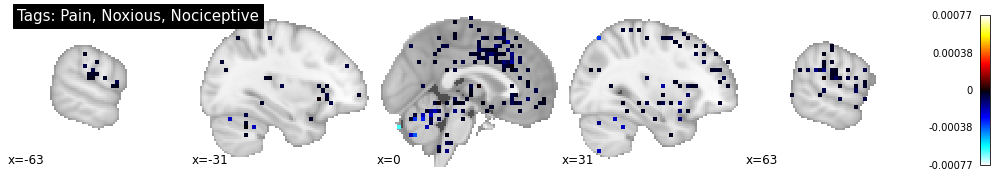

In [345]:
plotting.plot_stat_map(
    prob_img_nl, 
    title='Tags: Pain, Noxious, Nociceptive', 
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

In [77]:
with nl.scope as e:
    
    e.FilteredByTermA[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'awareness')
    )
    
    e.FilteredByTermB[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'consciousness')
    )
    
    '''e.filtered_docs[e.d] = (
        e.docs_pain[e.d] &
        ~(e.docs_noxious[e.d]) &
        ~(e.docs_nociceptive[e.d])
    )'''
    
    res = nl.solve_all()

In [78]:
a = set(res['FilteredByTermA'].as_pandas_dataframe()['s'].values)
b = set(res['FilteredByTermB'].as_pandas_dataframe()['s'].values)


In [79]:
len(a)

290

In [80]:
len(b)

74

In [82]:
a1 = a - b
a2 = b - a
print(len(a1), len(a2))

273 57


In [ ]:
with nl.scope as e:
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'noxious')
    )
    
    e.FilteredByTerm[e.t, e.s] = (
        e.TermInStudy[e.t, e.s] &
        (e.t == 'nociceptive')
    )
    
    (e.VoxelReported @ e.exp(-e.d / 5.0))[e.x1, e.y1, e.z1, e.s] = (
        e.FocusReported(e.x2, e.y2, e.z2, e.s)
        & e.Voxel(e.x1, e.y1, e.z1)
        & (e.d == e.EUCLIDEAN(e.x1, e.y1, e.z1, e.x2, e.y2, e.z2))
        & (e.d < 4)
    )
    
    e.Result[e.x, e.y, e.z, e.fold, e.PROB[e.x, e.y, e.z, e.fold]] = (
       (
           e.VoxelReported[e.x, e.y, e.z, e.s] 
       ) // (
           e.SelectedStudy[e.s] 
           & e.FilteredByTerm[e.t, e.s] 
           & e.StudyFolds[e.s, e.fold]
       )  
    )
    
    e.ResultMean[e.x, e.y, e.z, e.mean(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]    
    )

    e.ResultStd[e.x, e.y, e.z, e.std(e.PROB)] = (
        e.Result[e.x, e.y, e.z, e.fold, e.PROB]
    )

    e.ResultSummaryStats[
        e.x, e.y, e.z, e.prob_mean, e.prob_std
    ] = (
        e.ResultMean[e.x, e.y, e.z, e.prob_mean] &
        e.ResultStd[e.x, e.y, e.z, e.prob_std]
    )
    
    e.VoxelActivationImg[agg_create_region_overlay_MNI[e.x, e.y, e.z, e.p]] = (
        e.ResultMean(e.x, e.y, e.z, e.p)
    )
    
    
    res_noc_nox = nl.solve_all()